# 16. 다음에 볼 영화 예측하기

## 루브릭
- Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
- RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다
- 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.

## 1. Session-Based Recommendation

Movielens 1M Dataset을 기반으로 Session-Based Recommendation 시스템 제작하기

In [1]:
# 모듈 import
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print('Setup completed ^_____^')

Setup completed ^_____^


In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.4.1
2.6.0


## 1. 데이터 전처리

### (1) Data Load

In [3]:
# data path를 정의한다.

data_path = Path('./data/') 
train_path = data_path / 'ratings.dat'

# 데이터 path에서 data를 load 한다.

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


위 데이터를 살펴 보니 지난 실습과는 다른 몇가지 특징들이 보인다.
- SessionID 대신 UserID 항목을 사용하고 있다.
- 이 데이터 셋은 명확한 1회 세션의 SessionID를 포함하지 않는다.
- UserID가 SessionID 역할을 해야 한다.
- 시간을 협정세계시(UTC time)형식으로 표현하였다.
- Rating 정보가 포함되어 있다.
- Rating 정보가 추천과 어떤 관계를 가질 수 있을지 고민해할 필요가 있다. 
- Rating 이 낮은 데이터의 처리와 Rating이 높은 데이터의 처리 방법에 대한 고민

### (2) 시간 형식 변경
UTC time을 알아 보기 쉽도록 변경한다.

In [4]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date

In [5]:
# head 확인
# 날짜 형식이 변경된 것을 확인 할 수 있다.

data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43


In [6]:
# tail 확인
# 날짜 형식이 변경된 것을 확인 할 수 있다.

data.tail()

,UserId,ItemId,Rating,Time
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26
1000042,6040,1221,4,2001-08-20 22:44:15


In [7]:
# 기록의 시작과 끝을 확인해 보자
# 2000년 4월 25일 부터 2003년 2월 28일까지 기록 된 것을 확인 할 수 있다.

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


In [8]:
# 유저수(세션 수)와 아이템 수

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [9]:
# 각 유저별 리뷰의 개수 (몇 개의 영화를 시청했는가)

session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [10]:
# User 별 수치 데이터 확인
print(f'median   : {session_length.median()}')
print(f'mean     : {session_length.mean()}')
print(f'min      : {session_length.min()}')
print(f'max      : {session_length.max()}')
print(f'quantile : {session_length.quantile(0.999)}')

median   : 96.0
mean     : 165.5975165562914
min      : 20
max      : 2314
quantile : 1343.181000000005


In [11]:
# 최다 리뷰자 데이터 확인해보기

long_user = session_length[session_length==2314].index[0]

In [12]:
data['UserId'] == long_user

31         False
22         False
27         False
37         False
24         False
           ...  
1000019    False
999988     False
1000172    False
1000167    False
1000042    False
Name: UserId, Length: 1000209, dtype: bool

In [13]:
# ling_user = 4169 아이디의 데이터를 모두 뽑아 내라

data[data['UserId'] == long_user][:10] # 뽑아 낸 것에서 10개만 확인하겠다. 

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
696168,4169,3801,5,2000-08-04 05:11:21
696250,4169,3841,2,2000-08-04 05:11:21
697903,4169,3761,3,2000-08-04 05:11:21
697954,4169,3788,3,2000-08-04 05:11:21
695653,4169,3794,4,2000-08-04 05:11:59


우선 UserId를 하나의 Session으로 사용해보자

### (2) Session Length

In [14]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

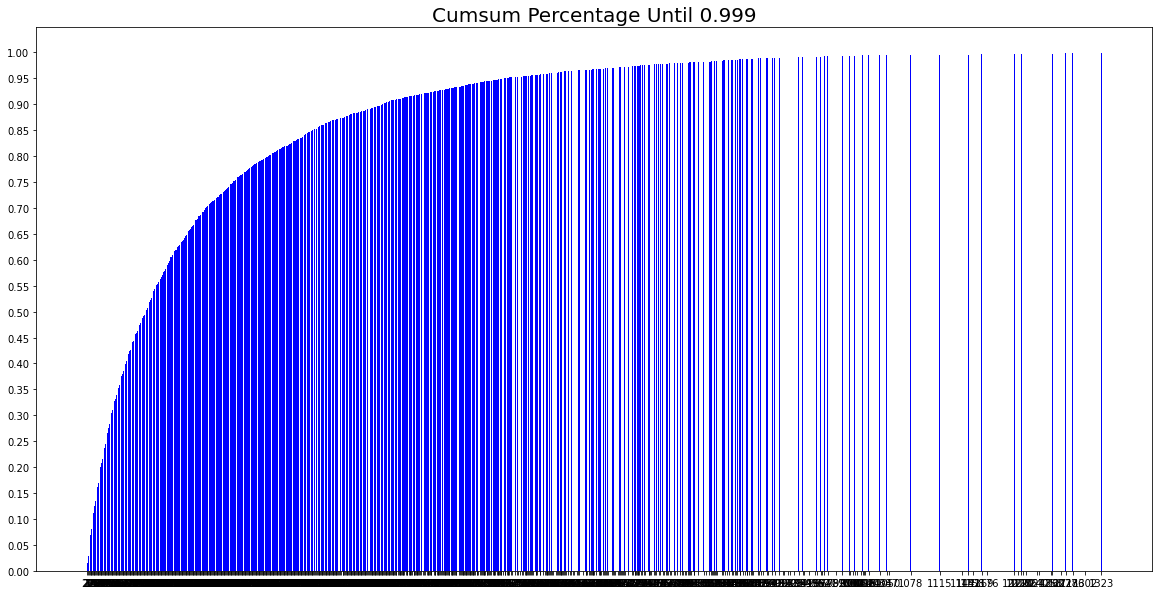

In [15]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### (3) Session Time

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


In [17]:
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

### (4) Data Cleansing

In [18]:
# short_session을 제거한 다음에 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통하여 지속적으로 제거

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data 

In [29]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### (5) Train/Valid/Test Split

In [19]:
# UserId를 기준으로 train, val, test = 0.7, 0.2, 0.1로 분리
tr = data[data['UserId'] <= 4228]
val = data[(data['UserId'] > 4228) & (data['UserId'] <= 5436)]
test = data[data['UserId'] > 5436]

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 706033
	 Sessions: 4228
	 Items: 3670
	 First Time : 2000-08-03 23:24:25
	 Last Time : 2003-02-28 09:51:39

* valid Set Stats Info
	 Events: 193436
	 Sessions: 1208
	 Items: 3434
	 First Time : 2000-06-03 14:20:31
	 Last Time : 2003-03-01 02:49:50

* test Set Stats Info
	 Events: 100740
	 Sessions: 604
	 Items: 3208
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2003-02-28 22:12:12



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

In [22]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. 미니배치의 구성

### (1) Session Dataset

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
pd.options.display.max_rows = 50
tr_dataset.df.head(50)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2001-01-01 07:00:19,0
22,1,1270,5,2001-01-01 07:00:55,1
27,1,1721,4,2001-01-01 07:00:55,2
37,1,1022,5,2001-01-01 07:00:55,3
24,1,2340,3,2001-01-01 07:01:43,4
36,1,1836,5,2001-01-01 07:02:52,5
3,1,3408,4,2001-01-01 07:04:35,6
7,1,2804,5,2001-01-01 07:11:59,7
47,1,1207,4,2001-01-01 07:11:59,8
0,1,1193,5,2001-01-01 07:12:40,9


In [26]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 704788, 706010, 706033])

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4225, 4226, 4227])

### (2) Session DataLoader

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2001-01-01 07:00:19,0
22,1,1270,5,2001-01-01 07:00:55,1
27,1,1721,4,2001-01-01 07:00:55,2
37,1,1022,5,2001-01-01 07:00:55,3
24,1,2340,3,2001-01-01 07:01:43,4
36,1,1836,5,2001-01-01 07:02:52,5
3,1,3408,4,2001-01-01 07:04:35,6
7,1,2804,5,2001-01-01 07:11:59,7
47,1,1207,4,2001-01-01 07:11:59,8
0,1,1193,5,2001-01-01 07:12:40,9


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
# 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만든다.
# input, output, mask의 감을 잡아 보자.

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 3. 모델 구성

### (1) Evaluation Metric
- 나에게 첫번째로 추천한 영화가 정답 아이템의 몇 번째에 해당하기 위해서 MRR 지표를 사용한다.
- 내가 선호하는 영화 중 추천해준 영화의 비율을 확인하기 위해서 Recall 지표를 사용한다.

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### (2) Model Architecture

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [34]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [37]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 3670)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    558300    
_________________________________________________________________
dropout (Dropout)            (512, 50)                 0         
_________________________________________________________________
dense (Dense)                (512, 3670)               187170    
Total params: 745,470
Trainable params: 745,470
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
train_model(model, args)

Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [04:05<03:30,  1.22s/it]


	 - Recall@20 epoch 1: 0.094707
	 - MRR@20    epoch 1: 0.020520



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [04:00<03:26,  1.19s/it]


	 - Recall@20 epoch 2: 0.186959
	 - MRR@20    epoch 2: 0.046941



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:45<03:13,  1.12s/it]


	 - Recall@20 epoch 3: 0.248965
	 - MRR@20    epoch 3: 0.065012



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:42<03:10,  1.10s/it]


	 - Recall@20 epoch 4: 0.275236
	 - MRR@20    epoch 4: 0.073289



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:40<03:08,  1.09s/it]


	 - Recall@20 epoch 5: 0.287922
	 - MRR@20    epoch 5: 0.078690



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:07,  1.08s/it]


	 - Recall@20 epoch 6: 0.296682
	 - MRR@20    epoch 6: 0.082190



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:37<03:06,  1.08s/it]


	 - Recall@20 epoch 7: 0.302222
	 - MRR@20    epoch 7: 0.084802



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:37<03:05,  1.07s/it]


	 - Recall@20 epoch 8: 0.305886
	 - MRR@20    epoch 8: 0.087009



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:36<03:05,  1.07s/it]


	 - Recall@20 epoch 9: 0.308352
	 - MRR@20    epoch 9: 0.088813



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:37<03:06,  1.08s/it]

	 - Recall@20 epoch 10: 0.310827
	 - MRR@20    epoch 10: 0.089845



모델 학습 결과를 보면 train_lost는 점점 감소하고, Recall@k 와 MRR@k 의 값이 증가하는 것을 확인할 수 있다. 따라서 정상적으로 학습되고 있는 상태라고 볼 수 있다.

## 5. 모델 테스트

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█████████████                                                        | 37/195 [00:39<02:49,  1.07s/it]

	 - Recall@20: 0.308858
	 - MRR@20: 0.089521



1. Recall@20: 0.308699  
- 총 20개의 영화를 추천받았을 때, 그 중에 6개가 선호하는 영화에 포함

2. MRR@20: 0.089521 
- 내가 선호하는 영화의 Ranking이 있을 때, 처음으로 추천받은 영화가 얼마나 높은 Ranking의 우선순위를 갖는지 판단하는 값 
- 이 데이터에서는 영화 별 Rating Data가 있긴 하였으나 Rating이 겹치는 영화들이 많이 있고, MRR값은 항상 첫 번째로 나오는 아이템만 신경쓰는 단점을 가지고 있다. 큰 의미가 없는 것으로 판단.

## 6. 모델 성능 향상시키기

### (1) learning rate 변경
- 아직 더 학습할 수 있는 가능성이 있다고 생각하여 학습률을 증가시켜서 10 epoch 만큼 다시 훈련시켜 보았다.

In [41]:
args_1 = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)
model_1 = create_model(args_1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(512, 1, 3670)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    558300    
_________________________________________________________________
dropout_1 (Dropout)          (512, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (512, 3670)               187170    
Total params: 745,470
Trainable params: 745,470
Non-trainable params: 0
_________________________________________________________________


In [42]:
train_model(model_1, args_1)

Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:39<03:07,  1.09s/it]


	 - Recall@20 epoch 1: 0.301033
	 - MRR@20    epoch 1: 0.084021



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:37<03:06,  1.08s/it]


	 - Recall@20 epoch 2: 0.313728
	 - MRR@20    epoch 2: 0.091729



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:06,  1.08s/it]


	 - Recall@20 epoch 3: 0.312403
	 - MRR@20    epoch 3: 0.092505



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:06,  1.08s/it]


	 - Recall@20 epoch 4: 0.309822
	 - MRR@20    epoch 4: 0.091769



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:39<03:07,  1.08s/it]


	 - Recall@20 epoch 5: 0.308613
	 - MRR@20    epoch 5: 0.091541



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:07,  1.08s/it]


	 - Recall@20 epoch 6: 0.307114
	 - MRR@20    epoch 6: 0.091028



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:36<03:05,  1.07s/it]


	 - Recall@20 epoch 7: 0.304620
	 - MRR@20    epoch 7: 0.090643



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:36<03:05,  1.07s/it]


	 - Recall@20 epoch 8: 0.303431
	 - MRR@20    epoch 8: 0.090300



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:06,  1.08s/it]


	 - Recall@20 epoch 9: 0.301129
	 - MRR@20    epoch 9: 0.089363



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:06,  1.08s/it]

	 - Recall@20 epoch 10: 0.300153
	 - MRR@20    epoch 10: 0.089076



In [43]:
test_model(model_1, args_1, test)

Evaluation:  19%|█████████████                                                        | 37/195 [00:40<02:51,  1.08s/it]

	 - Recall@20: 0.297825
	 - MRR@20: 0.086917



- learning rate를 10배 증가시킨 0.01로 설정
- 2 epoch에 학습 완료되고 점점 낮아져서 학습 진행되지 않음

### (2) Hidden size 변경

In [44]:
args_2 = Args(tr, val, test, batch_size=512, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_2 = create_model(args_2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(512, 1, 3670)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 100), (512, 100)]  1131600   
_________________________________________________________________
dropout_2 (Dropout)          (512, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (512, 3670)               370670    
Total params: 1,502,270
Trainable params: 1,502,270
Non-trainable params: 0
_________________________________________________________________


In [45]:
train_model(model_2, args_2)

Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [04:00<03:26,  1.19s/it]


	 - Recall@20 epoch 1: 0.152963
	 - MRR@20    epoch 1: 0.038891



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:46<03:13,  1.12s/it]


	 - Recall@20 epoch 2: 0.262541
	 - MRR@20    epoch 2: 0.070033



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:40<03:09,  1.09s/it]


	 - Recall@20 epoch 3: 0.289391
	 - MRR@20    epoch 3: 0.080199



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:07,  1.08s/it]


	 - Recall@20 epoch 4: 0.305335
	 - MRR@20    epoch 4: 0.086873



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:36<03:05,  1.07s/it]


	 - Recall@20 epoch 5: 0.315507
	 - MRR@20    epoch 5: 0.091574



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:07,  1.08s/it]


	 - Recall@20 epoch 6: 0.322324
	 - MRR@20    epoch 6: 0.094532



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:07,  1.08s/it]


	 - Recall@20 epoch 7: 0.325147
	 - MRR@20    epoch 7: 0.096282



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:37<03:06,  1.08s/it]


	 - Recall@20 epoch 8: 0.327090
	 - MRR@20    epoch 8: 0.097517



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:38<03:06,  1.08s/it]


	 - Recall@20 epoch 9: 0.328057
	 - MRR@20    epoch 9: 0.098852



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:36<03:05,  1.07s/it]

	 - Recall@20 epoch 10: 0.329208
	 - MRR@20    epoch 10: 0.098822



In [46]:
test_model(model_2, args_2, test)

Evaluation:  19%|█████████████                                                        | 37/195 [00:40<02:51,  1.08s/it]

	 - Recall@20: 0.320946
	 - MRR@20: 0.095708



- Hidden size를 50에서 100으로 증가시시킴 
- 다른 모델들과 동일하게 10 epoch을 학습시켰을 때, Recall과 MRR이 소폭 상승

### (3) Dropout 변경

In [47]:
args_3 = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)
model_3 = create_model(args_3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(512, 1, 3670)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    558300    
_________________________________________________________________
dropout_3 (Dropout)          (512, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (512, 3670)               187170    
Total params: 745,470
Trainable params: 745,470
Non-trainable params: 0
_________________________________________________________________


In [48]:
train_model(model_3, args_3)

Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [04:06<03:31,  1.22s/it]


	 - Recall@20 epoch 1: 0.087891
	 - MRR@20    epoch 1: 0.019395



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:59<03:25,  1.19s/it]


	 - Recall@20 epoch 2: 0.147016
	 - MRR@20    epoch 2: 0.034041



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:51<03:18,  1.15s/it]


	 - Recall@20 epoch 3: 0.206132
	 - MRR@20    epoch 3: 0.051582



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:47<03:14,  1.12s/it]


	 - Recall@20 epoch 4: 0.246065
	 - MRR@20    epoch 4: 0.063114



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:45<03:12,  1.11s/it]


	 - Recall@20 epoch 5: 0.264117
	 - MRR@20    epoch 5: 0.068821



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:43<03:11,  1.11s/it]


	 - Recall@20 epoch 6: 0.276677
	 - MRR@20    epoch 6: 0.073214



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:42<03:10,  1.10s/it]


	 - Recall@20 epoch 7: 0.284441
	 - MRR@20    epoch 7: 0.076119



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:42<03:10,  1.10s/it]


	 - Recall@20 epoch 8: 0.289517
	 - MRR@20    epoch 8: 0.078236



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:41<03:09,  1.10s/it]


	 - Recall@20 epoch 9: 0.294042
	 - MRR@20    epoch 9: 0.080297



Evaluation:  54%|████████████████████████████████████▋                               | 202/375 [03:40<03:09,  1.09s/it]

	 - Recall@20 epoch 10: 0.298277
	 - MRR@20    epoch 10: 0.081983



In [49]:
test_model(model_3, args_3, test)

Evaluation:  19%|█████████████                                                        | 37/195 [00:40<02:51,  1.09s/it]

	 - Recall@20: 0.301520
	 - MRR@20: 0.084318



## 결과 분석

In [86]:
# 결과 데이터를 로딩

rd_tmp = pd.read_csv("./data/result_data1.csv")
rd_df = rd_tmp.copy()

rd2_tmp = pd.read_csv("./data/result_data2.csv")
rd2_df = rd2_tmp.copy()

In [57]:
rd_df.head()

,epoch,Recall@20_1,MRR@20_1,Recall@20_2,MRR@20_2,Recall@20_3,MRR@20_3,Recall@20_4,MRR@20_4
0,1,0.094707,0.020520,0.089521,0.084021,0.152963,0.038891,0.087891,0.019395
1,2,0.186959,0.046941,0.313728,0.091729,0.262541,0.070033,0.147016,0.034041
2,3,0.248965,0.065012,0.312403,0.092505,0.289391,0.080199,0.206132,0.051582
3,4,0.275236,0.073289,0.309822,0.091769,0.305335,0.086873,0.246065,0.063114
4,5,0.287922,0.078690,0.308613,0.091541,0.315507,0.091574,0.264117,0.068821


In [67]:
epoch = rd_df['epoch']
recall20_1 = rd_df['Recall@20_1']
recall20_2 = rd_df['Recall@20_2']
recall20_3 = rd_df['Recall@20_3']
recall20_4 = rd_df['Recall@20_4']

MRR20_1 = rd_df['MRR@20_1']
MRR20_2 = rd_df['MRR@20_2']
MRR20_3 = rd_df['MRR@20_3']
MRR20_4 = rd_df['MRR@20_4']

### 학습 & validation 결과

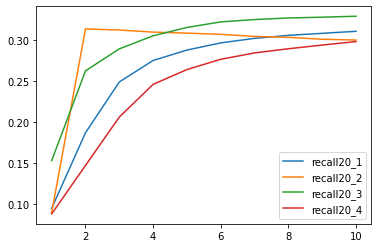

In [90]:
plt.plot(epoch, recall20_1, epoch, recall20_2,epoch, recall20_3, epoch, recall20_4)
plt.legend(('recall20_1', 'recall20_2', 'recall20_3', 'recall20_4'))
plt.show()

- 1번 기준모델 
- 2번 learning rate 변경 모델
- 3번 hidden size 변경
- 4번 drop out 변경

1. 동일한 10 epoch를 학습 시킨 경우 hidden size를 변경한 모델의 Recall이 가장 높은 것을 확인할 수 있다
2. learning rate를 0.01로 10배 증가 시킨 모델의 경우에는 2epoch까지 Reacll이 가파르게 상승 하여 다른 수정모델보다 높에 나타났으나 이후 더이상 제대로 학습이 진행되지 않고 하락 하는 모습을 보인다.

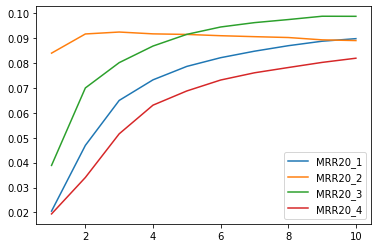

In [91]:
plt.plot(epoch, MRR20_1, epoch, MRR20_2,epoch, MRR20_3, epoch, MRR20_4)
plt.legend(('MRR20_1', 'MRR20_2', 'MRR20_3', 'MRR20_4'))
plt.show()

- 1번 기준모델 
- 2번 learning rate 변경 모델
- 3번 hidden size 변경
- 4번 drop out 변경

1. Reall과 마찬가지로 동일한 10 epoch를 학습 시킨 경우 hidden size를 변경한 모델의 MRR이 가장 높은 것을 확인할 수 있다
2. learning rate를 0.01로 10배 증가 시킨 모델의 경우에는 2epoch까지 MRR이 가파르게 상승 하여 다른 수정모델보다 높에 나타났으나 이후 더이상 제대로 학습이 진행되지 않고 하락 하는 모습을 보인다.

In [88]:
rd2_df.head()

,Recall@20_1,MRR@20_1,Recall@20_2,MRR@20_2,Recall@20_3,MRR@20_3,Recall@20_4,MRR@20_4
0,0.308858,0.089521,0.297825,0.086917,0.320946,0.095708,0.30152,0.084318


### Test 결과 

Test 데이터에 적용한 결과 역시 hidden size를 변경한 모델의 경우가 가장 높게 나왔다.

<BarContainer object of 4 artists>

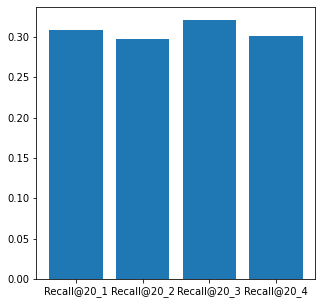

In [125]:
label_category = ['Recall@20_1', 'Recall@20_2', 'Recall@20_3', 'Recall@20_4']
data = [0.308858, 0.297825, 0.320946, 0.30152]

plt.figure(figsize=(5,5))

xtick_label_position = list(range(len(label_category))) ## x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, label_category) ## x축 눈금 라벨 출력

plt.bar(xtick_label_position, data) ## 바차트 출력

#plt.show()

<BarContainer object of 4 artists>

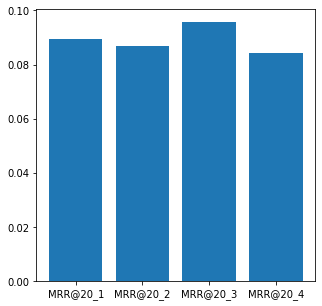

In [126]:
label_category2 = ['MRR@20_1', 'MRR@20_2', 'MRR@20_3', 'MRR@20_4']
data2 = [0.089521, 0.086917, 0.095708, 0.084318]

plt.figure(figsize=(5,5))

xtick_label_position2 = list(range(len(label_category2))) ## x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position2, label_category2) ## x축 눈금 라벨 출력

plt.bar(xtick_label_position2, data2) ## 바차트 출력

#plt.show()

## 회고록

이번노드는 큰 어려움 없이 진행한 노드 인것 같다. 
일단 코드도 전반적으로 이해하려고 노력하면서 했지만 역시 완벽하게 다 이해 하는 것을 아직 무리다.
새로 장만한 딥러닝용 컴퓨터에 세팅한 로컬환경을 테스트 할 수 있었다.
데이터 톤 이후에 허겁지겁 하느라 좀 서두른 감이 있지만 나름 선방한듯